In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import astropy as py
import pyspeckit
import astropy.units as u
import pandas as pd

from iminuit.cost import LeastSquares
from iminuit import Minuit

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import constants
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.stats import akaike_info_criterion

from scipy import constants as const
from scipy import optimize
from scipy.stats import chisquare
from scipy.stats import norm
from scipy.stats import gaussian_kde

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path, PathFromCenter

from pyspeckit.cubes.mapplot import MapPlotter

%matplotlib inline
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'
plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'out',
                     'ytick.direction': 'in'})

my_figsize = (5, 5)

In [94]:
rms = 0.00179

vlsr = 8.3



In [53]:
def Gaussian(x, A, mu, width):
    return A*np.exp(-(x-mu)**2/(2.0*width**2))

def Gaussian_2comp(x, A1, mu1, width1, A2, mu2, width2):
    return A1*np.exp(-(x-mu1)**2/(2.0*width1**2)) + A2*np.exp(-(x-mu2)**2/(2.0*width2**2))

def Gaussian_3comp(x, A1, mu1, width1, A2, mu2, width2, A3, mu3, width3):
    return A1*np.exp(-(x-mu1)**2/(2.0*width1**2)) + A2*np.exp(-(x-mu2)**2/(2.0*width2**2)) + A3*np.exp(-(x-mu3)**2/(2.0*width3**2))

In [54]:
def load_myCube( file_in):
    cube = pyspeckit.Cube(file_in)
    cube.xarr.refX = freq_line
    cube.xarr.velocity_convention = 'radio'
    cube.xarr.convert_to_unit('km/s')
    return cube

In [55]:
file_cube = 'Documents/C18O/B335_C18O_medsub.fits'

freq_line = rest_freq = 219.5603541 * u.GHz

Cube = SpectralCube.read(file_cube).with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                                  rest_value=rest_freq)

cube = load_myCube(file_cube)

In [56]:
cube.header['CDELT2'] * u.deg.to(u.arcsec)

0.050000000000004

In [57]:
cube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                 1000                                                  
NAXIS2  =                 1000                                                  
NAXIS3  =                  120                                                  
BMAJ    =   8.984900622747E-05                                                  
BMIN    =   6.727410627415E-05                                                  
BPA     =   5.446205540102E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'B335    '                                                            
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   2.195581569765E+

In [199]:
x = xpix = 505
y = ypix = 500
Spec = cube.get_spectrum(ypix,xpix)

In [200]:
vmin = 6; vmax = 12
tpeak_min = 3*rms; tpeak_max = 500e-3
dv_min = 0.05; dv_max = 6.0
F = False
T = True

In [196]:
#guesses = np.array([10e-3, 6.2, 1.5, 25e-3, 6.8, 0.3, 25e-3, 7.8, 1])
#guesses = [0.1, 8.15, 0.17, 0.1, 8.75, 0.17]
guesses = [0.02, 7.8, 0.1, 0.02, 8, 0.1]
#guesses = [0.03, 7.5, 0.2, 0.03, 8, 0.2, 0.02, 8.6, 0.2]

Spec.specfit(fittype='gaussian', guesses=guesses,
             limits=[(tpeak_min,tpeak_max), (vmin,vmax), (dv_min,dv_max), (tpeak_min,tpeak_max), (vmin,vmax), (dv_min,dv_max)],
            limited=[(T,T), (T,T), (T,T), (T,T), (T,T), (T,T)])

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,120 [pyspeckit.spectrum.interactive]


support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'title' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.
support for accessing str attributes such as 'lower' from PhysicalType instances is deprecated since 4.3 and will be removed in a subsequent release.


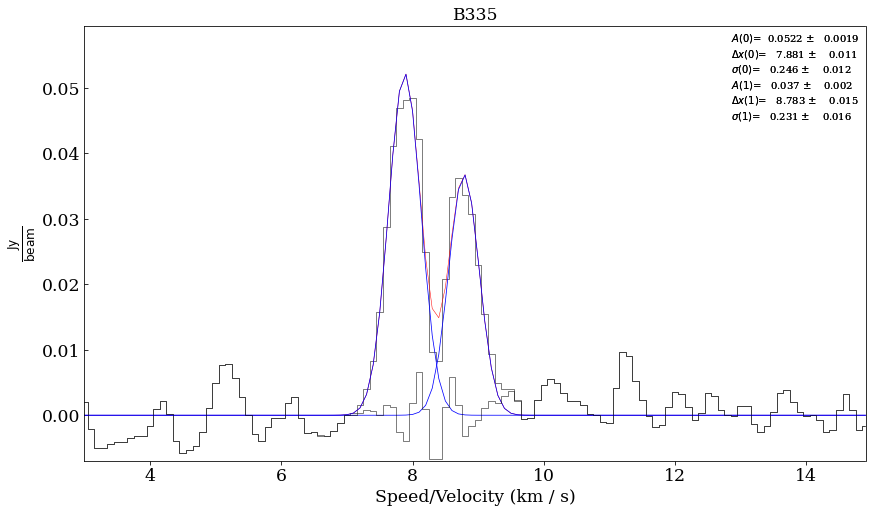

In [197]:
Spec.plotter()
Spec.specfit.plot_fit()
Spec.specfit.plot_components()
Spec.specfit.plotresiduals(axis=Spec.plotter.axis, clear=False, label=False)

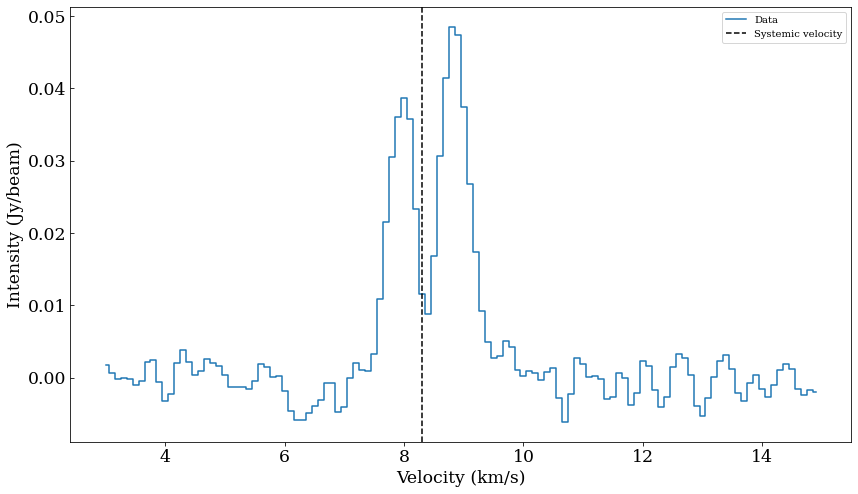

In [202]:
test_JEP = Gaussian(Cube.spectral_axis.value, 0.15, 8.1, 0.2)
test_JEP1 = Gaussian(Cube.spectral_axis.value, 0.07, 9, 0.3)

Cube[:,xpix,ypix].quicklook(label='Data')
#plt.step(Cube.spectral_axis.value, test_JEP, label='1st comp')
#plt.step(Cube.spectral_axis.value, test_JEP1, label='2nd comp')

#plt.step(Cube.spectral_axis.value, test_JEP + test_JEP1, label='sum')
plt.ylabel('Intensity (Jy/beam)')
plt.xlabel('Velocity (km/s)')
plt.axvline(8.3, linestyle = 'dashed', color = 'black', label = 'Systemic velocity')
plt.legend()

In [63]:
file_1comp = 'Documents/C18O/Spec_C18O_fit_01kms_5snr.fits'
#file_2comp = 'Documents/H13CO/Spec_H13CO_32_fit_2comp_5snr.fits'
file_2comp = 'Documents/C18O/Spec_C18O_fit_5snr_2comp_slurm.fits'
file_3comp = 'Documents/C18O/Spec_C18O_fit_5snr_3comp.fits'

In [64]:
data_1comp, hd_1comp = fits.getdata(file_1comp, header=True)
data_2comp, hd_2comp = fits.getdata(file_2comp, header=True)
data_3comp, hd_3comp = fits.getdata(file_3comp, header=True)

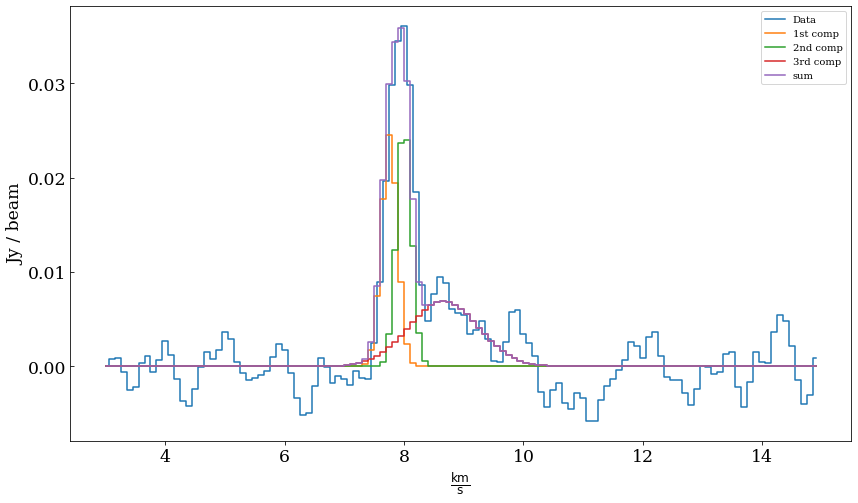

In [65]:
test = Gaussian(Cube.spectral_axis.value,
                          data_3comp[0,xpix,ypix],
                          data_3comp[1,xpix,ypix],
                          data_3comp[2,xpix,ypix])
test1 = Gaussian(Cube.spectral_axis.value,
                          data_3comp[3,xpix,ypix],
                          data_3comp[4,xpix,ypix],
                          data_3comp[5,xpix,ypix])
test2 = Gaussian(Cube.spectral_axis.value,
                          data_3comp[6,xpix,ypix],
                          data_3comp[7,xpix,ypix],
                          data_3comp[8,xpix,ypix])

Cube[:,xpix,ypix].quicklook(label = 'Data')
plt.step(Cube.spectral_axis.value, test, label='1st comp')
plt.step(Cube.spectral_axis.value, test1, label='2nd comp')
plt.step(Cube.spectral_axis.value, test2, label='3rd comp')
plt.step(Cube.spectral_axis.value, test + test1 + test2 , label='sum')
plt.legend()

In [66]:
file_par = 'Documents/H13CO/Spec_H13CO_32_fit_2comp_5snr copie.fits'
data, hd = fits.getdata(file_par, header=True)
hd_2d = hd.copy()
key_list = ['NAXIS3', 'CRPIX3', 'SPECSYS', 'CDELT3', 'CUNIT3', 'CTYPE3', 'CRVAL3']
for key_i in key_list:
    hd_2d.remove(key_i)
hd_2d['NAXIS'] = 2
hd_2d['WCSAXES'] = 2
hd_2d['BITPIX'] = 8

hd_2d['BUNIT'] = 'km/s'

In [67]:
def chi2(y_data, y_model, err) :
    return np.sum(np.square(y_data - y_model)/err**2)

def AIC(chi2_low, chi2_high, Delta_k = 3.) :
    return 2*Delta_k + chi2_low - chi2_high

In [68]:
chi2_0comp = chi2(Cube[:,x,y].value, 0, rms)

In [69]:
chi2_1comp=chi2(Cube[:,x,y].value, Gaussian(Cube.spectral_axis.value,data_1comp[0,x,y],data_1comp[1,x,y],data_1comp[2,x,y]), rms)

In [70]:
AIC(chi2_1comp, chi2_0comp)

-1612.5993768608344

In [71]:
chi2_2comp=chi2(Cube[:,x,y].value,Gaussian_2comp(Cube.spectral_axis.value,
                                                 data_2comp[0,x,y],
                                                 data_2comp[1,x,y],
                                                 data_2comp[2,x,y],
                                                 data_2comp[3,x,y],
                                                 data_2comp[4,x,y],
                                                 data_2comp[5,x,y]), rms)

In [72]:
AIC(chi2_2comp, chi2_1comp)

3.0326258541289235

In [73]:
chi2_3comp=chi2(Cube[:,x,y].value,Gaussian_3comp(Cube.spectral_axis.value,
                                                 data_3comp[0,x,y],
                                                 data_3comp[1,x,y],
                                                 data_3comp[2,x,y],
                                                 data_3comp[3,x,y],
                                                 data_3comp[4,x,y],
                                                 data_3comp[5,x,y],
                                                 data_3comp[6,x,y],
                                                 data_3comp[7,x,y],
                                                 data_3comp[8,x,y]), rms)

In [74]:
AIC(chi2_3comp, chi2_2comp)

-105.24300303948019

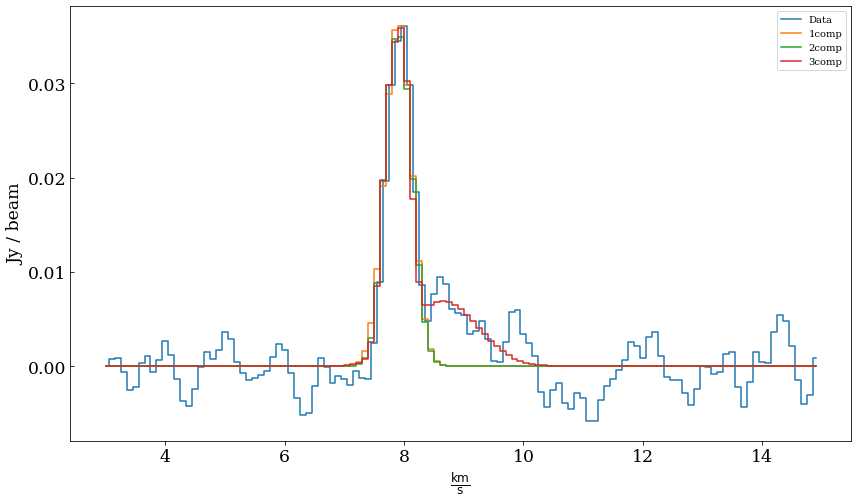

In [75]:
test_1st = Gaussian(Cube.spectral_axis.value,
                    data_1comp[0,xpix,ypix],
                    data_1comp[1,xpix,ypix],
                    data_1comp[2,xpix,ypix])

test_2nd = Gaussian_2comp(Cube.spectral_axis.value,
                          data_2comp[0,xpix,ypix],
                          data_2comp[1,xpix,ypix],
                          data_2comp[2,xpix,ypix],
                          data_2comp[3,xpix,ypix],
                          data_2comp[4,xpix,ypix],
                          data_2comp[5,xpix,ypix])

test_3rd = Gaussian_3comp(Cube.spectral_axis.value,
                          data_3comp[0, xpix,ypix],
                          data_3comp[1, xpix,ypix],
                          data_3comp[2, xpix,ypix],
                          data_3comp[3, xpix,ypix],
                          data_3comp[4, xpix,ypix],
                          data_3comp[5, xpix,ypix],
                          data_3comp[6, xpix,ypix],
                          data_3comp[7, xpix,ypix],
                          data_3comp[8, xpix,ypix])

Cube[:,xpix,ypix].quicklook(label = 'Data')

plt.step(Cube.spectral_axis.value,test_1st, label = '1comp')
plt.step(Cube.spectral_axis.value,test_2nd, label = '2comp')
plt.step(Cube.spectral_axis.value,test_3rd, label = '3comp')
plt.legend()

In [76]:
zoom_size = 400

#bestparam = [[[] for j in range(250)] for i in range(250)]
Image = np.zeros(shape=(zoom_size, zoom_size))
bestparam = np.zeros(shape=(15, zoom_size, zoom_size))
i_zoom = 320
j_zoom = 320

for n in range(zoom_size):
    
    i = n + i_zoom

    for p in range(zoom_size):
        
        j = p + j_zoom
        
        chi2_0comp=chi2(Cube[:, i, j].value, 0, rms)
        
        chi2_1comp=chi2(Cube[:, i, j].value, Gaussian(Cube.spectral_axis.value,
                                                    data_1comp[0, i, j],
                                                    data_1comp[1, i, j],
                                                    data_1comp[2, i, j]), rms)
        
        
        aic_test1 = AIC(chi2_1comp, chi2_0comp, Delta_k=3.)
        
        if aic_test1 < -10 : 
            
            #1 comp model better than 0 comp model 
            
            bestparam[0:3, n, p] = data_1comp[0:3, i, j]
            bestparam[9:12, n, p] = data_1comp[3:6, i, j]
            
            Image[n, p] = 1
            
            chi2_2comp=chi2(Cube[:, i, j].value, Gaussian_2comp(Cube.spectral_axis.value,
                                                         data_2comp[0, i, j],
                                                         data_2comp[1, i, j],
                                                         data_2comp[2, i, j],
                                                         data_2comp[3, i, j],
                                                         data_2comp[4, i, j],
                                                         data_2comp[5, i, j]), rms)
            
            aic_test2 = AIC(chi2_2comp, chi2_1comp, Delta_k=3.)
                
            
            if aic_test2 < -10 and np.abs(data_2comp[1, i, j] - data_2comp[4, i, j]) > 0.1 :
                
                #2 comp model better than 1 comp model 
                
                bestparam[0:6, n, p] = data_2comp[0:6, i, j]
                bestparam[6:12, n, p] = data_2comp[6:12, i, j]
                
                Image[n, p] = 2

                chi2_3comp=chi2(Cube[:, i, j].value, Gaussian_3comp(Cube.spectral_axis.value,
                                                         data_3comp[0, i, j],
                                                         data_3comp[1, i, j],
                                                         data_3comp[2, i, j],
                                                         data_3comp[3, i, j],
                                                         data_3comp[4, i, j],
                                                         data_3comp[5, i, j],
                                                         data_3comp[6, i, j],
                                                         data_3comp[7, i, j],
                                                         data_3comp[8, i, j]), rms)
                
                aic_test3 = AIC(chi2_3comp, chi2_2comp, Delta_k=3.)
                
                if aic_test3 < -10 and np.abs(data_2comp[1, i, j] - data_2comp[4, i, j]) > 0.1 and np.abs(data_2comp[1, i, j] - data_2comp[7, i, j]) > 0.1 and np.abs(data_2comp[7, i, j] - data_2comp[4, i, j]) > 0.1 :
                    
                    #3 comp model better than 2 comp model 
                    
                    bestparam[0:9, n, p] = data_3comp[0:9, i, j]
                    bestparam[9:15, n, p] = data_3comp[9:15, i, j]
                
                    Image[n, p] = 3
                    
            else :
                
                chi2_3comp=chi2(Cube[:, i, j].value, Gaussian_3comp(Cube.spectral_axis.value,
                                                         data_3comp[0, i, j],
                                                         data_3comp[1, i, j],
                                                         data_3comp[2, i, j],
                                                         data_3comp[3, i, j],
                                                         data_3comp[4, i, j],
                                                         data_3comp[5, i, j],
                                                         data_3comp[6, i, j],
                                                         data_3comp[7, i, j],
                                                         data_3comp[8, i, j]), rms)
                
                aic_test3 = AIC(chi2_3comp, chi2_1comp, Delta_k=6.)
                
                if aic_test3 < -10 and np.abs(data_2comp[1, i, j] - data_2comp[4, i, j]) > 0.1 and np.abs(data_2comp[1, i, j] - data_2comp[7, i, j]) > 0.1 and np.abs(data_2comp[7, i, j] - data_2comp[4, i, j]) > 0.1 :
                    
                    #3 comp model better than 2 comp model 
                    
                    bestparam[0:9, n, p] = data_3comp[0:9, i, j]
                    bestparam[9:15, n, p] = data_3comp[9:15, i, j]
                
                    Image[n, p] = 3

In [128]:
Cube[:,180,180]

<OneDSpectrum [ 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                2.3101241e-12, 2.0608250e-12,-5.1731568e-13, 4.3904424e-12,
                7.3551139e-12,-6.2943444e-12,-1.0691110e-14,-4.2484497e-12,
                3.4295858e-11,-2.7035494e-12,-2.2507787e-11, 3.5026877e-11,
                9.7092168e-11,-9.2868768e-11, 2.3195957e-11, 1.8029037e-11,
               -2.2818387e-10,-4.9165814e-11,-3.4449893e-10,-6.8620283e-12,
            

In [141]:
data_test = np.zeros(len(Cube.spectral_axis))

for n in range(zoom_size):
    
    i = n + i_zoom

    for p in range(zoom_size):
        
        j = p + j_zoom
        
        for k in range(len(Cube.spectral_axis)) :
            
            data_test[k] += Cube[:,n,p][k].value

KeyboardInterrupt: 

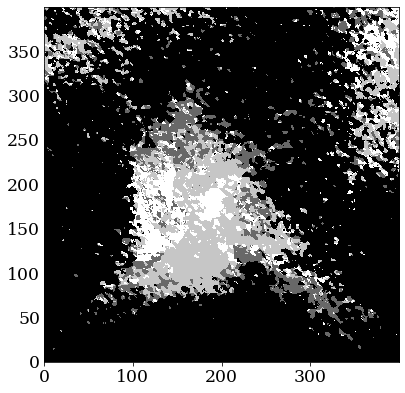

In [146]:
import matplotlib.cm as cm
fig = plt.figure()
ax2 = fig.add_subplot(121)
ax2.imshow(Image, interpolation='nearest', cmap=cm.Greys_r)
ax2.invert_yaxis()

#plt.xlim(120,130)
#plt.ylim(120,130)

clean_param = bestparam
Image_clean = Image

for i in range(300,zoom_size):
    
    for j in range(120):
        
        clean_param[:, i, j] = 0.0 
        Image_clean[i, j] = 0.0
        

In [79]:
bestparam[:,445-i_zoom,449-j_zoom]

array([1.61903104e-02, 7.65210522e+00, 1.39641216e-01, 3.02848773e-02,
       8.02111704e+00, 1.63434064e-01, 8.49378041e-03, 8.60662069e+00,
       1.11868718e-01, 2.79576617e-03, 4.50098189e-02, 3.00866891e-02,
       1.79355606e-03, 2.77473965e-02, 2.18409333e-02])

In [80]:
441-i_zoom

121

In [81]:
zoom_size

400

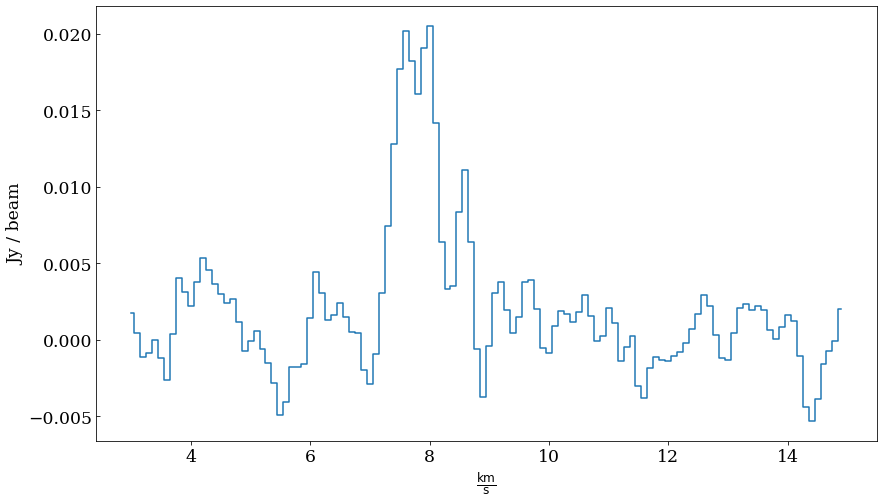

In [82]:
Cube[:,449, 445].quicklook()

In [186]:
Line_width_blue = bestparam[0, :, :] * np.nan
Vel_blue = bestparam[0, :, :] * np.nan 
Amp_blue = bestparam[0, :, :] * np.nan
width_narrow = 0.5
vel_min = 7.7

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_min < bestparam[1, i, j] < vlsr and bestparam[2, i, j] < width_narrow :
            
            Line_width_blue[i, j] = bestparam[2, i, j]
            Vel_blue[i, j] = bestparam[1, i, j]
            Amp_blue[i, j] = bestparam[0, i, j]
                
        if Image[i, j] == 2.0 :
            
                if vel_min < bestparam[4, i, j] < vlsr and bestparam[5, i, j] < width_narrow :
                    
                    if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr : 
                        
                        Line_width_blue[i, j] = bestparam[5, i, j]
                        Vel_blue[i, j] = bestparam[4, i, j]
                        Amp_blue[i, j] = bestparam[3, i, j]
                    
        if Image[i, j] == 3.0 :
            
            if vel_min < bestparam[4, i, j] < vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_blue[i, j] = bestparam[5, i, j]
                    Vel_blue[i, j] = bestparam[4, i, j]
                    Amp_blue[i, j] = bestparam[3, i, j]
                    #Image_blue[i, j] = Image[i, j]
                
                    if vel_min < bestparam[7, i, j] < vlsr and bestparam[8, i, j] < width_narrow and bestparam[7, i, j] > bestparam[1, i, j] :
                    
                        Line_width_blue[i, j] = bestparam[8, i, j]
                        Vel_blue[i, j] = bestparam[7, i, j]
                        Amp_blue[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_min < bestparam[7, i, j] < vlsr and bestparam[8, i, j] < width_narrow :
                
                if (bestparam[1, i, j] < vlsr and bestparam[7, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_blue[i, j] = bestparam[8, i, j]
                    Vel_blue[i, j] = bestparam[7, i, j]
                    Amp_blue[i, j] = bestparam[6, i, j]
                    #Image_blue[i, j] = Image[i, j]
                
                    if vel_min < bestparam[1, i, j] < vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1

In [84]:
Line_width_blue = bestparam[0, :, :] * np.nan
Vel_blue = bestparam[0, :, :] * np.nan 
Amp_blue = bestparam[0, :, :] * np.nan

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if 7.7 < bestparam[1, i, j] < 8.3 :
            
            Line_width_blue[i, j] = bestparam[2, i, j]
            Vel_blue[i, j] = bestparam[1, i, j]
            Amp_blue[i, j] = bestparam[0, i, j]
                
        if Image[i, j] == 2.0 :
            
                if 7.7 < bestparam[4, i, j] < 8.4 and bestparam[4, i, j] > bestparam[1, i, j] :
                    
                    Line_width_blue[i, j] = bestparam[5, i, j]
                    Vel_blue[i, j] = bestparam[4, i, j]
                    Amp_blue[i, j] = bestparam[3, i, j]
                    
        if Image[i, j] == 3.0 :
            
                if 7.7 < bestparam[4, i, j] < 8.4 and bestparam[4, i, j] > bestparam[1, i, j] :
                    
                    Line_width_blue[i, j] = bestparam[5, i, j]
                    Vel_blue[i, j] = bestparam[4, i, j]
                    Amp_blue[i, j] = bestparam[3, i, j]
                    
                    if 7.7 < bestparam[7, i, j] < 8.4 and bestparam[7, i, j] > bestparam[4, i, j] :
                        
                        Line_width_blue[i, j] = bestparam[8, i, j]
                        Vel_blue[i, j] = bestparam[7, i, j]
                        Amp_blue[i, j] = bestparam[6, i, j]
                    
                elif 7.7 < bestparam[7, i, j] < 8.4 and bestparam[7, i, j] > bestparam[1, i, j] :
                    
                    Line_width_blue[i, j] = bestparam[8, i, j]
                    Vel_blue[i, j] = bestparam[7, i, j]
                    Amp_blue[i, j] = bestparam[6, i, j]
                    
                    if 7.7 < bestparam[4, i, j] < 8.4 and bestparam[4, i, j] > bestparam[7, i, j] :
                        
                        Line_width_blue[i, j] = bestparam[5, i, j]
                        Vel_blue[i, j] = bestparam[4, i, j]
                        Amp_blue[i, j] = bestparam[3, i, j]

In [188]:
Line_width_red = bestparam[0, :, :] * np.nan
Vel_red = bestparam[0, :, :] * np.nan 
Amp_red = bestparam[0, :, :] * np.nan
width_narrow = 0.5
vel_max = 10.5

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
        if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] < width_narrow :
            
            Line_width_red[i, j] = bestparam[2, i, j]
            Vel_red[i, j] = bestparam[1, i, j]
            Amp_red[i, j] = bestparam[0, i, j]
            
        if Image[i, j] == 2.0 :
            
            if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] < width_narrow :
                
                if 10 > bestparam[4, i, j] > 8.3 and bestparam[2, i, j] < width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
                    
            elif 10 > bestparam[4, i, j] > 8.3 and bestparam[2, i, j] < width_narrow :
                
                Line_width_red[i, j] = bestparam[5, i, j]
                Vel_red[i, j] = bestparam[4, i, j]
                Amp_red[i, j] = bestparam[3, i, j]
            
        if Image[i, j] == 3.0 :
            
            if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] < width_narrow :
                
                if 10 > bestparam[4, i, j] > 8.3 and bestparam[5, i, j] < width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
                    
                    if 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                        
                        Line_width_red[i, j] = bestparam[8, i, j]
                        Vel_red[i, j] = bestparam[7, i, j]
                        Amp_red[i, j] = bestparam[6, i, j]
                    
                elif 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[0, i, j] :
                    
                    Line_width_red[i, j] = bestparam[8, i, j]
                    Vel_red[i, j] = bestparam[7, i, j]
                    Amp_red[i, j] = bestparam[6, i, j]
                    
            elif 10 > bestparam[4, i, j] > 8.3 and bestparam[5, i, j] < width_narrow :
                
                Line_width_red[i, j] = bestparam[5, i, j]
                Vel_red[i, j] = bestparam[4, i, j]
                Amp_red[i, j] = bestparam[3, i, j]
                
                if 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                        
                        Line_width_red[i, j] = bestparam[8, i, j]
                        Vel_red[i, j] = bestparam[7, i, j]
                        Amp_red[i, j] = bestparam[6, i, j]
                        
            elif 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] < width_narrow:
                
                Line_width_red[i, j] = bestparam[8, i, j]
                Vel_red[i, j] = bestparam[7, i, j]
                Amp_red[i, j] = bestparam[6, i, j]
                


In [170]:
Line_width_red = bestparam[0, :, :] * np.nan
Vel_red = bestparam[0, :, :] * np.nan 
Amp_red = bestparam[0, :, :] * np.nan
width_narrow = 2
vel_max = 10.5

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
            
        if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] < width_narrow :
            
            Line_width_red[i, j] = bestparam[2, i, j]
            Vel_red[i, j] = bestparam[1, i, j]
            Amp_red[i, j] = bestparam[0, i, j]
                
        if Image[i, j] == 2.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] < width_narrow :
                    
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] < vlsr : 
                        
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
                    
        if Image[i, j] == 3.0 :
            
            if vel_max > bestparam[4, i, j] > vlsr and bestparam[5, i, j] < width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[4, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
                    #Image_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] < width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                    
                        Line_width_red[i, j] = bestparam[8, i, j]
                        Vel_red[i, j] = bestparam[7, i, j]
                        Amp_red[i, j] = bestparam[6, i, j]
                    
                    overlaps +=1
                    
            elif vel_max > bestparam[7, i, j] > vlsr and bestparam[8, i, j] < width_narrow :
                
                if (bestparam[1, i, j] > vlsr and bestparam[7, i, j] > bestparam[1, i, j]) or bestparam[1, i, j] > vlsr :
                
                    Line_width_red[i, j] = bestparam[8, i, j]
                    Vel_red[i, j] = bestparam[7, i, j]
                    Amp_red[i, j] = bestparam[6, i, j]
                    #Image_red[i, j] = Image[i, j]
                
                    if vel_max > bestparam[1, i, j] > vlsr and bestparam[2, i, j] < width_narrow :
                    
                        overlaps +=1

In [184]:
Line_width_other = bestparam[0, :, :] * np.nan
Vel_other = bestparam[0, :, :] * np.nan 
Amp_other = bestparam[0, :, :] * np.nan
width_narrow = 0.4
vel_max = 10.5

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
        if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] > width_narrow :
            
            Line_width_other[i, j] = bestparam[2, i, j]
            Vel_other[i, j] = bestparam[1, i, j]
            Amp_other[i, j] = bestparam[0, i, j]
            
        if Image[i, j] == 2.0 :
            
            if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] > width_narrow :
                
                if 10 > bestparam[4, i, j] > 8.3 and bestparam[2, i, j] > width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                    Line_width_other[i, j] = bestparam[5, i, j]
                    Vel_other[i, j] = bestparam[4, i, j]
                    Amp_other[i, j] = bestparam[3, i, j]
                    
            elif 10 > bestparam[4, i, j] > 8.3 and bestparam[2, i, j] > width_narrow :
                
                Line_width_other[i, j] = bestparam[5, i, j]
                Vel_other[i, j] = bestparam[4, i, j]
                Amp_other[i, j] = bestparam[3, i, j]
            
        if Image[i, j] == 3.0 :
            
            if 10 > bestparam[1, i, j] > 8.3 and bestparam[2, i, j] > width_narrow :
                
                if 10 > bestparam[4, i, j] > 8.3 and bestparam[5, i, j] > width_narrow and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                    Line_width_other[i, j] = bestparam[5, i, j]
                    Vel_other[i, j] = bestparam[4, i, j]
                    Amp_other[i, j] = bestparam[3, i, j]
                    
                    if 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] > width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                        
                        Line_width_other[i, j] = bestparam[8, i, j]
                        Vel_other[i, j] = bestparam[7, i, j]
                        Amp_other[i, j] = bestparam[6, i, j]
                    
                elif 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] > width_narrow and bestparam[6, i, j] > bestparam[0, i, j] :
                    
                    Line_width_other[i, j] = bestparam[8, i, j]
                    Vel_other[i, j] = bestparam[7, i, j]
                    Amp_other[i, j] = bestparam[6, i, j]
                    
            elif 10 > bestparam[4, i, j] > 8.3 and bestparam[5, i, j] > width_narrow :
                
                Line_width_other[i, j] = bestparam[5, i, j]
                Vel_other[i, j] = bestparam[4, i, j]
                Amp_other[i, j] = bestparam[3, i, j]
                
                if 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] > width_narrow and bestparam[6, i, j] > bestparam[3, i, j] :
                        
                        Line_width_other[i, j] = bestparam[8, i, j]
                        Vel_other[i, j] = bestparam[7, i, j]
                        Amp_other[i, j] = bestparam[6, i, j]
                        
            elif 10 > bestparam[7, i, j] > 8.3 and bestparam[8, i, j] > width_narrow:
                
                Line_width_other[i, j] = bestparam[8, i, j]
                Vel_other[i, j] = bestparam[7, i, j]
                Amp_other[i, j] = bestparam[6, i, j]
                


In [191]:
Line_width_other = bestparam[0, :, :] * np.nan
Vel_other = bestparam[0, :, :] * np.nan 
Amp_other = bestparam[0, :, :] * np.nan

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
        if 7 < bestparam[1, i, j] < 7.7 :
            
            Line_width_other[i, j] = bestparam[2, i, j]
            Vel_other[i, j] = bestparam[1, i, j]
            Amp_other[i, j] = bestparam[0, i, j]
            
        if Image[i, j] == 2.0 :
            
            if 7 < bestparam[4, i, j] < 7.7 and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                Line_width_other[i, j] = bestparam[5, i, j]
                Vel_other[i, j] = bestparam[4, i, j]
                Amp_other[i, j] = bestparam[3, i, j]
                    
        if Image[i, j] == 3.0 :
            
                if 7 < bestparam[4, i, j] < 7.7 and bestparam[3, i, j] > bestparam[0, i, j] :
                    
                    Line_width_other[i, j] = bestparam[5, i, j]
                    Vel_other[i, j] = bestparam[4, i, j]
                    Amp_other[i, j] = bestparam[3, i, j]
                    
                    if 7 < bestparam[7, i, j] < 7.7 and bestparam[6, i, j] > bestparam[3, i, j] :
                        
                        Line_width_other[i, j] = bestparam[8, i, j]
                        Vel_other[i, j] = bestparam[7, i, j]
                        Amp_other[i, j] = bestparam[6, i, j]
                    
                elif 7 < bestparam[7, i, j] < 7.7 and bestparam[6, i, j] > bestparam[0, i, j] :
                    
                    Line_width_other[i, j] = bestparam[8, i, j]
                    Vel_other[i, j] = bestparam[7, i, j]
                    Amp_other[i, j] = bestparam[6, i, j]
                    

In [88]:
Line_width_red = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]
Line_width_blue = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]
Vel_blue = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]
Vel_red = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]
Amp_red = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]
Amp_blue = bestparam[0, :, :] * np.nan #[[[] for j in range(len(bestparam))] for i in range(len(bestparam))]

overlaps = 0

for i in range(zoom_size) : 
    
    for j in range(zoom_size) :
        
#        if Image[i, j] == 1.0 :
            
        if 7.5 < bestparam[1, i, j] < 8.4 :
            
            Line_width_blue[i, j] = bestparam[2, i, j]
            Vel_blue[i, j] = bestparam[1, i, j]
            Amp_blue[i, j] = bestparam[0, i, j]
            
        elif 9 > bestparam[1, i, j] > 8.4 : 
                
            Line_width_red[i, j] = bestparam[2, i, j]
            Vel_red[i, j] = bestparam[1, i, j]
            Amp_red[i, j] = bestparam[0, i, j]
                
        if Image[i, j] == 2.0 :
            
            if 7.5 < bestparam[1, i, j] < 8.4 :
            
                Line_width_blue[i, j] = bestparam[2, i, j]
                Vel_blue[i, j] = bestparam[1, i, j]
                Amp_blue[i, j] = bestparam[0, i, j]
            
                if 9 > bestparam[4, i, j] > 8.4 :
                    
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
            
            elif 9 > bestparam[4, i, j] > 8.4 :
                
                Line_width_red[i, j] = bestparam[5, i, j]
                Vel_red[i, j] = bestparam[4, i, j]
                Amp_red[i, j] = bestparam[3, i, j]
            
                if 7.5 < bestparam[1, i, j] < 8.4 :
                
                    Line_width_blue[i, j] = bestparam[2, i, j]
                    Vel_blue[i, j] = bestparam[1, i, j]
                    Amp_blue[i, j] = bestparam[0, i, j]
                    
                
            elif 7.5 < bestparam[4, i, j] < 8.4 :
                
                Line_width_blue[i, j] = bestparam[5, i, j]
                Vel_blue[i, j] = bestparam[4, i, j]
                Amp_blue[i, j] = bestparam[3, i, j]
                
                if 9 > bestparam[1, i, j] > 8.4 :
                    
                    Line_width_red[i, j] = bestparam[2, i, j]
                    Vel_red[i, j] = bestparam[1, i, j]
                    Amp_red[i, j] = bestparam[0, i, j]
            
            
            
""" 
            if (8.8 > bestparam[4, i, j] > 8.4) :#and (bestparam[5, i, j] < 1) :
                    
                    Line_width_red[i, j] = bestparam[5, i, j]
                    Vel_red[i, j] = bestparam[4, i, j]
                    Amp_red[i, j] = bestparam[3, i, j]
                    
                    if 7.8 < bestparam[1, i, j] < 8.35:
                        
                        Line_width_blue[i, j] = bestparam[2, i, j]
                        Vel_blue[i, j] = bestparam[1, i, j]
                        Amp_blue[i, j] = bestparam[0, i, j]
                    
            elif (7.8 < bestparam[4, i, j] < 8.35) :
                
                    Line_width_blue[i, j] = bestparam[5, i, j]
                    Vel_blue[i, j] = bestparam[4, i, j]
                    Amp_blue[i, j] = bestparam[3, i, j]
                    
                    if (8.8 > bestparam[1, i, j] > 8.4) :
                        
                        Line_width_red[i, j] = bestparam[2, i, j]
                        Vel_red[i, j] = bestparam[1, i, j]
                        Amp_red[i, j] = bestparam[0, i, j]
                
        if Image[i, j] == 3.0 :
            
            if (10 > bestparam[7, i, j] > 8.4) :
                    
                    Line_width_red[i, j] = bestparam[8, i, j]
                    Vel_red[i, j] = bestparam[7, i, j]
                    Amp_red[i, j] = bestparam[6, i, j]
                    
                    if 10 > bestparam[1, i, j] > 8.4 or 10 > bestparam[4, i, j] > 8.4:
                        
                        overlaps += 1
                    
            elif (7.5 < bestparam[7, i, j] < 8.4) :
                
                    Line_width_blue[i, j] = bestparam[8, i, j]
                    Vel_blue[i, j] = bestparam[7, i, j]
                    Amp_blue[i, j] = bestparam[6, i, j]
                    
                    if 7.5 < bestparam[1, i, j] < 8.4 or 7.5 < bestparam[4, i, j] < 8.4 :
                        
                        overlaps += 1

print("overlaps are: {0}".format(overlaps))

            elif 10 > bestparam[i][j][4] > 8.4 :
                
                Line_width_red[i][j] = bestparam[i][j][5]
                Vel_red[i][j] = bestparam[i][j][4]
                Amp_red[i][j] = bestparam[i][j][3]
            
                if 7.5 < bestparam[i][j][1] < 8.4 :
                
                    Line_width_blue[i][j] = bestparam[i][j][2]
                    Vel_blue[i][j] = bestparam[i][j][1]
                    Amp_blue[i][j] = bestparam[i][j][0]
                    
                else : 
            
                    Line_width_blue[i][j] = np.nan
                    Vel_blue[i][j] = np.nan
                    Amp_blue[i][j] = np.nan
                
            elif 7.5 < bestparam[i][j][4] < 8.4 :
                
                Line_width_blue[i][j] = bestparam[i][j][5]
                Vel_blue[i][j] = bestparam[i][j][4]
                Amp_blue[i][j] = bestparam[i][j][3]
                
                if 10 > bestparam[i][j][1] > 8.4 :
                    
                    Line_width_red[i][j] = bestparam[i][j][2]
                    Vel_red[i][j] = bestparam[i][j][1]
                    Amp_red[i][j] = bestparam[i][j][0]
                
                else : 
            
                    Line_width_red[i][j] = np.nan
                    Vel_red[i][j] = np.nan
                    Amp_red[i][j] = np.nan
                
###
"""

' \n            if (8.8 > bestparam[4, i, j] > 8.4) :#and (bestparam[5, i, j] < 1) :\n                    \n                    Line_width_red[i, j] = bestparam[5, i, j]\n                    Vel_red[i, j] = bestparam[4, i, j]\n                    Amp_red[i, j] = bestparam[3, i, j]\n                    \n                    if 7.8 < bestparam[1, i, j] < 8.35:\n                        \n                        Line_width_blue[i, j] = bestparam[2, i, j]\n                        Vel_blue[i, j] = bestparam[1, i, j]\n                        Amp_blue[i, j] = bestparam[0, i, j]\n                    \n            elif (7.8 < bestparam[4, i, j] < 8.35) :\n                \n                    Line_width_blue[i, j] = bestparam[5, i, j]\n                    Vel_blue[i, j] = bestparam[4, i, j]\n                    Amp_blue[i, j] = bestparam[3, i, j]\n                    \n                    if (8.8 > bestparam[1, i, j] > 8.4) :\n                        \n                        Line_width_red[i, j

In [89]:
file_dv_C18O_width_red = 'Documents/C18O/B335_C18O_vlsr_5snr_width_red.fits'
file_dv_C18O_width_blue = 'Documents/C18O/B335_C18O_vlsr_5snr_width_blue.fits'
file_vc_C18O_vlsr_red = 'Documents/C18O/B335_C18O_vlsr_5snr_vel_red.fits'
file_vc_C18O_vlsr_blue = 'Documents/C18O/B335_C18O_vlsr_5snr_vel_blue.fits'
file_vc_C18O_vlsr_very_blue = 'Documents/C18O/B335_C18O_vlsr_5snr_vel_very_blue.fits'
file_dv_C18O_width_very_blue = 'Documents/C18O/B335_C18O_vlsr_5snr_width_very_blue.fits'

In [192]:
file_par = 'Documents/C18O/Spec_C18O_fit_5snr_2comp copie.fits'
data, hd = fits.getdata(file_par, header=True)
hd_2d = hd.copy()
key_list = ['NAXIS3', 'CRPIX3', 'SPECSYS', 'CDELT3', 'CUNIT3', 'CTYPE3', 'CRVAL3']
for key_i in key_list:
    hd_2d.remove(key_i)
hd_2d['NAXIS'] = 2
hd_2d['WCSAXES'] = 2
hd_2d['BITPIX'] = 8
hd_2d['BUNIT'] = 'km/s'

data[:,:,:] = 0.0

snr_min = 3.

for n in range(zoom_size) : 
    
    i = n + i_zoom
    
    for p in range(zoom_size) :
        
        j = p + j_zoom
        
        if Amp_blue[n, p] > snr_min * rms :#and Line_width_blue[n, p] < 0.5 :   
            
            data[5, i, j] = np.abs(Line_width_blue[n, p])
            data[4, i, j] = Vel_blue[n, p]
        
        if Amp_red[n, p] > snr_min * rms :#and Line_width_red[n, p] < 0.5 : 
            
            data[2, i, j] = np.abs(Line_width_red[n, p])
            data[1, i, j] = Vel_red[n, p]
            
        if Amp_other[n, p] > snr_min * rms :#and Vel_other[n, p] < 7.4 :#and Line_width_other[n, p] < 0.5 : 
            
            data[8, i, j] = np.abs(Line_width_other[n, p])
            data[7, i, j] = Vel_other[n, p]
        
fits.writeto(file_dv_C18O_width_red, np.squeeze(data[2,:,:]), hd_2d, overwrite=True)
fits.writeto(file_dv_C18O_width_blue, np.squeeze(data[5,:,:]), hd_2d, overwrite=True)
fits.writeto(file_vc_C18O_vlsr_red, np.squeeze(data[1,:,:]), hd_2d, overwrite=True)
fits.writeto(file_vc_C18O_vlsr_blue, np.squeeze(data[4,:,:]), hd_2d, overwrite=True)

fits.writeto(file_dv_C18O_width_very_blue, np.squeeze(data[8,:,:]), hd_2d, overwrite=True)
fits.writeto(file_vc_C18O_vlsr_very_blue, np.squeeze(data[7,:,:]), hd_2d, overwrite=True)

In [91]:
bad = Vel_other == 0.0

Vel_other[bad] = np.nan

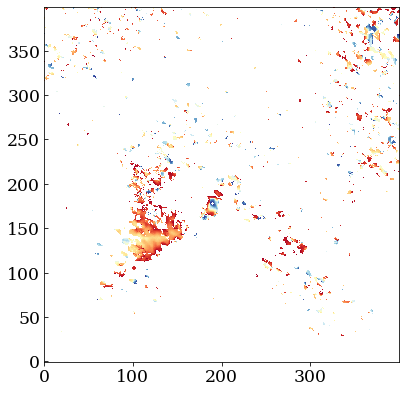

In [193]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.imshow(Vel_other, interpolation='nearest', cmap=cm.RdYlBu_r)
ax2.invert_yaxis()
#plt.ylim(135,150)
#plt.xlim(135, 150)
